In [1]:
import tensorflow
import imageio

print(tensorflow.__version__)
print(imageio.__version__)

2.6.0
2.9.0


In [2]:
import os
import glob
import time
import PIL
import imageio
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from IPython import display
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# 데이터셋 구성하기
cifar10 = tf.keras.datasets.cifar10

(train_x, _), (test_x, _) = cifar10.load_data()

train_x.shape

(50000, 32, 32, 3)

학습에 사용할 train_x의 이미지를 -1, 1로 정규화

In [4]:
print("max pixel:", train_x.max())
print("min pixel:", train_x.min())

max pixel: 255
min pixel: 0


In [5]:
train_x = (train_x - 127.5)/127.5
print("max pixel:", train_x.max())
print("min pixel:", train_x.min())

max pixel: 1.0
min pixel: -1.0


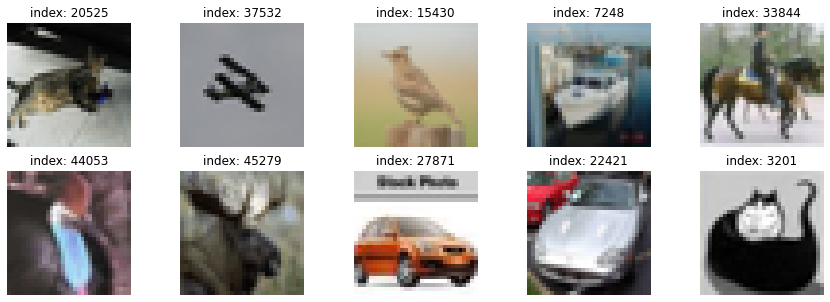

In [6]:
plt.figure(figsize=(15, 5))

for i in range(10):
    plt.subplot(2, 5, i+1)
    random_idx = np.random.randint(1, 50000)
    plt.imshow((train_x[random_idx]+1)/2)
    plt.title(f'index: {random_idx}')
    plt.axis('off')
plt.show()

In [7]:
BUFFER_SIZE = 60000

BATCH_SIZE = 256

train_dataset = tf.data.Dataset.from_tensor_slices(train_x).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

### 생성자 모델 구현

In [8]:
def make_generator_model():
    
    # Start
    model = tf.keras.Sequential()
    
    # First: Dense layer
    # units은 7x7x256, 편향은 사용하지 않음, 입력 값의 크기는 100차원 벡터
    model.add(layers.Dense(8*8*256, use_bias=False, input_shape=(100,)))

    # 배치 정규화 사용
    model.add(layers.BatchNormalization())

    # LeakyReLU 활성화 함수 사용
    model.add(layers.LeakyReLU())

    # Second: Reshape layer
    model.add(layers.Reshape((8, 8, 256)))
    
    # Third: Conv2DTranspose layer
    # 커널 크기는 5, stride는 1, 패딩은 사용, 편향은 사용하지 않음
    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))

    # 배치 정규화 사용
    model.add(layers.BatchNormalization())

    # LeakyReLU 활성화 함수 사용
    model.add(layers.LeakyReLU())

    # Fourth: Conv2DTranspose layer
    # 커널 크기는 5, stride는 2, 패딩은 사용, 편향은 사용하지 않음
    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    #assert model.output_shape == (None, 14, 14, 64)

    # 배치 정규화 사용
    model.add(layers.BatchNormalization())

    # LeakyReLU 활성화 함수 사용
    model.add(layers.LeakyReLU())

    # Fifth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(3, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    
    return model

In [9]:
generator_model = make_generator_model()
generator_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16384)             1638400   
_________________________________________________________________
batch_normalization (BatchNo (None, 16384)             65536     
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 16384)             0         
_________________________________________________________________
reshape (Reshape)            (None, 8, 8, 256)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 8, 8, 128)         819200    
_________________________________________________________________
batch_normalization_1 (Batch (None, 8, 8, 128)         512       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 8, 8, 128)         0

In [10]:
# 노이즈 생성
noise = tf.random.normal([1,100])
generated_image = generator_model(noise, training=False)
generated_image.shape

TensorShape([1, 32, 32, 3])

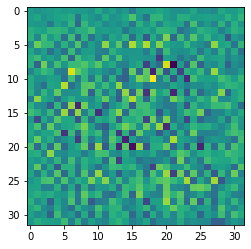

In [11]:
plt.imshow(generated_image[0, :, :, 0])

### 판별자 모델 구현

In [12]:
def make_discriminator_model():
    # Start
    model = tf.keras.Sequential()
    
    # First: Conv2D Layer
    # 필터의 크기는 5이며 64개 사용, stride는 2, 패딩은 사용, 입력 값의 크기는 준비된 흑백 사진
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[32, 32, 3]))

    # LeakyReLU 활성화 함수 사용
    model.add(layers.LeakyReLU())
    
    # Dropout은 0.3을 사용
    model.add(layers.Dropout(0.3))
    
    # Second: Conv2D Layer
    # 필터의 크기는 5이며 128개 사용, stride는 2, 패딩은 사용
    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    
    # LeakyReLU 활성화 함수 사용
    model.add(layers.LeakyReLU())
    
    # Dropout은 0.3을 사용
    model.add(layers.Dropout(0.3))
    
    # Third: Flatten Layer
    model.add(layers.Flatten())
    
    # Fourth: Dense Layer
    model.add(layers.Dense(1))
    
    return model

In [13]:
discriminator_model = make_discriminator_model()
discriminator_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 16, 16, 64)        4864      
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 16, 16, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 8, 8, 128)         204928    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 8, 8, 128)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 8, 8, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 8192)             

In [14]:
dicision = discriminator_model(generated_image, training=False)

### 손실함수

In [15]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [16]:
vector = [[1, 2, 3],
            [4, 5, 6]]

tf.ones_like(vector)

<tf.Tensor: shape=(2, 3), dtype=int32, numpy=
array([[1, 1, 1],
       [1, 1, 1]], dtype=int32)>

In [17]:
# generator_loss
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [18]:
# discriminator_loss
def discriminator_loss(real_output, fake_output):
    # 손실함수는 cross entropy를 사용, ones_like를 활용
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)

    # 손실함수는 cross entropy를 사용, zeros_like를 활용
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    
    # real_loss와 fake_loss를 더한 값
    total_loss = real_loss + fake_loss

    return total_loss

In [19]:
# discriminator accuracy
def discriminator_accuracy(real_output, fake_output):

    real_accuracy = tf.reduce_mean(tf.cast(tf.math.greater_equal(real_output, tf.constant([0.5])), tf.float32))

    fake_accuracy = tf.reduce_mean(tf.cast(tf.math.less(fake_output, tf.constant([0.5])), tf.float32))

    return real_accuracy, fake_accuracy

### 최적화 함수(optimizer)

In [20]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)

discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

noise_dim = 100

num_examples_to_generate = 16

  
# 매번 학습이 어떻게 진행되어가고 있는지를 확인하기 위해 생성자가 생성한 샘플을 확인
seed = tf.random.normal([num_examples_to_generate, noise_dim])

seed.shape

TensorShape([16, 100])

### 훈련과정 설계

In [21]:
@tf.function

def train_step(images): #(1) 입력데이터
    noise = tf.random.normal([BATCH_SIZE, noise_dim]) #(2) 생성자 입력 노이즈
    
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape: #(3) tf.GradientTape() 오픈
        generated_images = generator_model(noise, training=True) #(4) generated_images 생성
        
        #(5) discriminator 판별
        real_output = discriminator_model(images, training=True)
        fake_output = discriminator_model(generated_images, training=True)
        
        #(6) loss 계산
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

        #(7) accuracy 계산
        real_accuracy, fake_accuracy = discriminator_accuracy(real_output, fake_output)

    #(8) gradient 계산
    gradients_of_generator = gen_tape.gradient(gen_loss, generator_model.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator_model.trainable_variables)
    
    #(9) 모델 학습
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator_model.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator_model.trainable_variables))

    return gen_loss, disc_loss, real_accuracy, fake_accuracy #(10) 리턴값

### 한 단계씩 학습할 train_step과 함께 일정 간격으로 학습 현황을 볼 수 있는 샘플을 생성하는 함수

In [33]:
def generate_and_save_images(model, epoch, it, sample_seeds):

    predictions = model(sample_seeds, training=False)
    
    fig = plt.figure(figsize=(4, 4))
    
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, 0])
        plt.axis('off')

    plt.savefig('{}/aiffel/dcgan_newimage/cifar10/generated_samples/sample_epoch_{:04d}_iter_{:03d}.png'.format(os.getenv('HOME'), epoch, it))
    
    plt.show()

훈련 epoch마다 생성자/판별자의 loss 및 판별자의 실제/생성(real/fake) 이미지 판별 accuracy 히스토리(history)를 그래프로 시각화하는 함수

In [34]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6

def draw_train_history(history, epoch):
    plt.subplot(211)
    plt.plot(history['gen_loss'])
    plt.plot(history['disc_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('batch iters')
    plt.legend(['gen_loss', 'disc_loss'], loc='upper left')
    
    plt.plot(history['fake_accuracy'])
    plt.plot(history['real_accuracy'])
    plt.title('discriminator accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('batch iters')
    plt.legend(['fake_accuracy', 'real_accuracy'], loc='upper left')
    
    # training_history 디렉토리에 epoch 별 그래프 저장
    plt.savefig('{}/aiffel/dcgan_newimage/cifar10/training_history/train_history_{:04d}.png'
                    .format(os.getenv('HOME'), epoch))
    plt.show()

### 정기적으로 모델을 저장하기 위한 checkpoint

In [35]:
checkpoint_dir = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/training_checkpoints'

checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")

checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer, 
                                 discriminator_optimizer=discriminator_optimizer, 
                                 generator=generator_model, 
                                 discriminator=discriminator_model)

### 학습과정 진행

In [36]:
def train(dataset, epochs, save_every):
    start = time.time()
    history = {'gen_loss':[], 'disc_loss':[], 'real_accuracy':[], 'fake_accuracy':[]}

    for epoch in range(epochs):
        epoch_start = time.time()
        
        for it, image_batch in enumerate(dataset):
            gen_loss, disc_loss, real_accuracy, fake_accuracy = train_step(image_batch)
            history['gen_loss'].append(gen_loss)
            history['disc_loss'].append(disc_loss)
            history['real_accuracy'].append(real_accuracy)
            history['fake_accuracy'].append(fake_accuracy)
            
            if it % 50 == 0:
                display.clear_output(wait=True)
                generate_and_save_images(generator_model, epoch+1, it+1, seed) # 샘플 이미지 생성, 저장
                print('Epoch {} | iter {}'.format(epoch+1, it+1))
                print('Time for epoch {} : {} sec'.format(epoch+1, int(time.time()-epoch_start)))
        if (epoch + 1) % save_every == 0:
            checkpoint.save(file_prefix=checkpoint_prefix) # 모델 저장
        
        display.clear_output(wait=True)
        generate_and_save_images(generator_model, epochs, it, seed)
        print('Time for training : {} sec'.format(int(time.time()-start)))
        
        draw_train_history(history, epoch)

In [37]:
save_every = 5

EPOCHS = 50

In [38]:
tf.config.list_physical_devices("GPU") # 사용가능한 GPU 확인

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

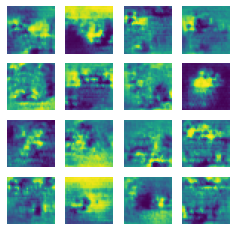

Time for training : 758 sec


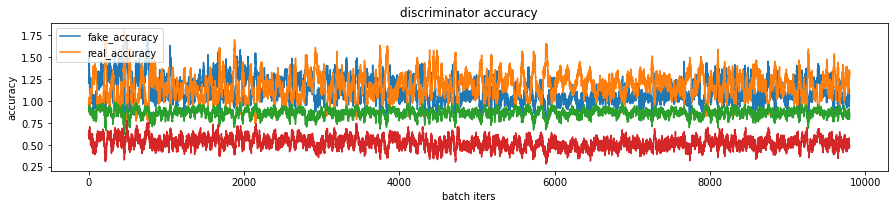

CPU times: user 12min 54s, sys: 1min 20s, total: 14min 15s
Wall time: 12min 39s


In [39]:
%%time
with tf.device('/GPU:0'):
    train(train_dataset, EPOCHS, save_every)

In [42]:
# 학습과정 시각화
image_file_dir = '/aiffel/aiffel/dcgan_newimage/cifar10/cifar10_dcgan.gif'

with imageio.get_writer(image_file_dir, mode='I') as writer:
    filenames = glob.glob('{}/aiffel/dcgan_newimage/cifar10/generated_samples/sample*.png'.format(os.getenv('HOME')))
    filenames = sorted(filenames)
    last = -1
    for i, filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)
        
!ls -l ~/aiffel/dcgan_newimage/cifar10/cifar10_dcgan.gif

-rw-r--r-- 1 root root 1327097 Nov 30 07:57 /aiffel/aiffel/dcgan_newimage/cifar10/cifar10_dcgan.gif


### 저장한 모델 로드

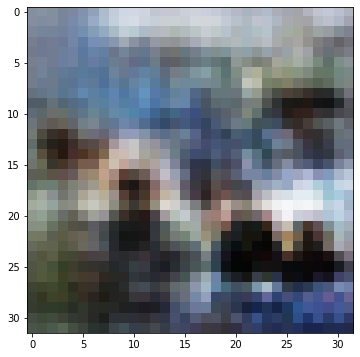

In [43]:
checkpoint_dir = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/training_checkpoints'

latest = tf.train.latest_checkpoint(checkpoint_dir)
checkpoint.restore(latest)

generator = checkpoint.generator
discriminator = checkpoint.discriminator

# 로드한 모델이 정상적으로 이미지를 생성하는지 확인해 봅니다. 
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

np_generated = generated_image.numpy()
np_generated = (np_generated * 127.5) + 127.5   # reverse of normalization
np_generated = np_generated.astype(int)
plt.imshow(np_generated[0])
plt.show()  # 정상적으로 모델이 로드되었다면 랜덤 이미지가 아니라 CIFAR-10 이미지가 그려질 것입니다.

In [44]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

### 훈련과정 개선

In [61]:
def make_generator_model2():
    
    # Start
    model = tf.keras.Sequential()
    
    model.add(layers.Dense(8*8*128, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization(momentum=0.9))
    model.add(layers.LeakyReLU(alpha=0.1))

    model.add(layers.Reshape((8, 8, 128)))
    
    model.add(layers.Conv2DTranspose(128, (4, 4), strides=(1, 1), padding='same'))
    model.add(layers.BatchNormalization(momentum=0.9))
    model.add(layers.LeakyReLU(alpha=0.1))
    
    model.add(layers.Conv2DTranspose(128, 4, strides=2, padding='same'))
    model.add(layers.BatchNormalization(momentum=0.9))
    model.add(layers.LeakyReLU(alpha=0.1))
    
    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same'))
    model.add(layers.BatchNormalization(momentum=0.9))
    model.add(layers.LeakyReLU(alpha=0.1))
    
    model.add(layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same'))
    model.add(layers.BatchNormalization(momentum=0.9))
    model.add(layers.LeakyReLU(alpha=0.1))

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    model.add(layers.BatchNormalization(momentum=0.9))
    model.add(layers.LeakyReLU(alpha=0.1))

    model.add(layers.Conv2DTranspose(3, kernel_size=(5, 5), strides=(1, 1), padding='same', activation='tanh'))
    
    return model

In [62]:
generator2 = make_generator_model2()
generator2.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 8192)              819200    
_________________________________________________________________
batch_normalization_21 (Batc (None, 8192)              32768     
_________________________________________________________________
leaky_re_lu_23 (LeakyReLU)   (None, 8192)              0         
_________________________________________________________________
reshape_5 (Reshape)          (None, 8, 8, 128)         0         
_________________________________________________________________
conv2d_transpose_21 (Conv2DT (None, 8, 8, 128)         262272    
_________________________________________________________________
batch_normalization_22 (Batc (None, 8, 8, 128)         512       
_________________________________________________________________
leaky_re_lu_24 (LeakyReLU)   (None, 8, 8, 128)        

In [63]:
noise = tf.random.normal([1, 100])
generated_image = generator2(noise, training=False)
generated_image.shape

TensorShape([1, 32, 32, 3])

In [69]:
def make_discriminator_model2():
    # Start
    model = tf.keras.Sequential()
    
    # First: Conv2D Layer
    model.add(layers.Conv2D(32, (3, 3), strides=(2, 2), input_shape=[32, 32, 3]))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dropout(0.25))
    
    # Second: Conv2D Layer
    model.add(layers.Conv2D(64, (3, 3), strides=(2, 2), padding='same'))
    model.add(layers.BatchNormalization(momentum=0.8))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dropout(0.25))
    
    model.add(layers.Conv2D(128, (3, 3), strides=(2, 2), padding='same'))
    model.add(layers.BatchNormalization(momentum=0.8))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dropout(0.25))
    
    model.add(layers.Conv2D(256, (3, 3), strides=(1, 1), padding='same'))
    model.add(layers.BatchNormalization(momentum=0.8))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dropout(0.25))

    # Third: Flatten Layer
    model.add(layers.Flatten())
    
    # Fourth: Dense Layer
    model.add(layers.Dense(1, activation='sigmoid'))
    return model

In [70]:
discriminator_model2 = make_discriminator_model2()
discriminator_model2.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 15, 15, 32)        896       
_________________________________________________________________
leaky_re_lu_37 (LeakyReLU)   (None, 15, 15, 32)        0         
_________________________________________________________________
dropout_10 (Dropout)         (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 8, 8, 64)          18496     
_________________________________________________________________
batch_normalization_33 (Batc (None, 8, 8, 64)          256       
_________________________________________________________________
leaky_re_lu_38 (LeakyReLU)   (None, 8, 8, 64)          0         
_________________________________________________________________
dropout_11 (Dropout)         (None, 8, 8, 64)         

In [71]:
save_every = 5
EPOCHS = 100

### Model2 학습

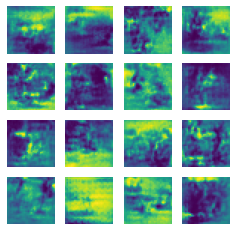

Time for training : 1531 sec


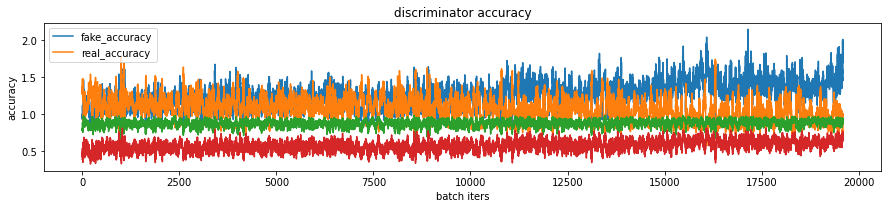

CPU times: user 26min 7s, sys: 2min 41s, total: 28min 48s
Wall time: 25min 33s


In [73]:
%%time
with tf.device('/GPU:0'):
    train(train_dataset, EPOCHS, save_every)

### 회고

- EPOCH을 100으로 증가
- 생성자 모델에서 여러 층을 더 쌓아 모델이 조금 더 학습할 수 있도록 설계하였습니다.
- 판변자 모델에서는 드롭아웃을 조금 낮추고 alpha,momentum의 값을 조금 조정하였습니다.
- Dropout의 값도 0.3에서 0.25로 하향시켰습니다.
- 모델을 개선을 시키는 과정에서 점차 출력 이미지가 어떤 형태인지 알아볼 수 있게 되었고, epoch 수를 증가시키면 모델이 더 이미지를 선명하게 생성한다는 결과를 볼 수 있었습니다.
- 후에 Epoch의 수를 대폭 증가시켜 학습을 시켜볼 예정입니다.
- 이번 학습을 통하여 이미지 생성 모델에 대한 이해를 증가시킬 수 있었습니다.
- matplotlib:imshow의 cmap을 통하여 원하는 색으로 이미지를 표시할 수 있음을 새로 알게 되었습니다.